In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Read data

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")

In [4]:
df.head()

,Date,DayOfWeek,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,IsDayAfterHoliday,temp_max,temp_min,temp_mean,humidity_max,humidity_min,NUMBER_INT,CO,MP10,O3,MP2.5,SO2
0,2015-01-01,Thu,3,1,1,0,1,0,33.9,20.6,25.912500,89.0,32.0,30,0.0,NaN,68.0,NaN,82.0
1,2015-01-02,Fri,4,1,1,0,0,1,32.9,21.0,26.050000,87.0,38.0,43,0.0,NaN,79.0,NaN,83.0
2,2015-01-03,Sat,5,1,1,1,0,0,33.5,20.2,26.683333,83.0,38.0,23,0.0,NaN,44.0,NaN,83.0
3,2015-01-04,Sun,6,1,1,1,0,0,30.6,22.2,25.641667,81.0,43.0,20,0.0,NaN,49.0,NaN,82.0
4,2015-01-05,Mon,0,2,1,0,0,0,30.8,20.8,25.520833,79.0,36.0,51,0.0,NaN,59.0,NaN,82.0


In [5]:
df.count()

Date                 1826
DayOfWeek            1826
DayOfWeekNum         1826
WeekOfYear           1826
Month                1826
IsWeekend            1826
IsHoliday            1826
IsDayAfterHoliday    1826
temp_max             1826
temp_min             1826
temp_mean            1826
humidity_max         1826
humidity_min         1826
NUMBER_INT           1826
CO                   1581
MP10                 1457
O3                   1265
MP2.5                1195
SO2                  1091
dtype: int64

### Set features

In [6]:
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'O3',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()

In [7]:
# add lag

df_final['O3_lag1'] = df_final['O3'].shift(1)
df_final['O3_lag2'] = df_final['O3'].shift(2)
df_final['O3_lag3'] = df_final['O3'].shift(3)

df_final['temp_min_lag1'] = df_final['temp_min'].shift(1)
df_final['temp_min_lag2'] = df_final['temp_min'].shift(2)
df_final['temp_min_lag3'] = df_final['temp_min'].shift(3)

# df_final['humidity_max_lag1'] = df_final['humidity_max'].shift(1)
# df_final['humidity_max_lag2'] = df_final['humidity_max'].shift(2)
# df_final['humidity_max_lag3'] = df_final['humidity_max'].shift(3)

In [8]:
df_final = df_final.dropna()

In [9]:
# Check non-null counts and data types
df_final.info()

# Check descriptive statistics
df_final.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Index: 1155 entries, 3 to 1677
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1155 non-null   object 
 1   DayOfWeekNum   1155 non-null   int64  
 2   WeekOfYear     1155 non-null   int64  
 3   Month          1155 non-null   int64  
 4   IsWeekend      1155 non-null   int64  
 5   IsHoliday      1155 non-null   int64  
 6   NUMBER_INT     1155 non-null   int64  
 7   O3             1155 non-null   float64
 8   temp_max       1155 non-null   float64
 9   temp_min       1155 non-null   float64
 10  humidity_max   1155 non-null   float64
 11  O3_lag1        1155 non-null   float64
 12  O3_lag2        1155 non-null   float64
 13  O3_lag3        1155 non-null   float64
 14  temp_min_lag1  1155 non-null   float64
 15  temp_min_lag2  1155 non-null   float64
 16  temp_min_lag3  1155 non-null   float64
dtypes: float64(10), int64(6), object(1)
memory usage: 162.4+ 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,1155,1155,2019-08-05,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekNum,1155.0,NaN,NaN,NaN,3.005195,2.015961,0.0,1.0,3.0,5.0,6.0
WeekOfYear,1155.0,NaN,NaN,NaN,26.490043,13.972325,1.0,15.0,27.0,38.0,52.0
Month,1155.0,NaN,NaN,NaN,6.511688,3.206713,1.0,4.0,7.0,9.0,12.0
IsWeekend,1155.0,NaN,NaN,NaN,0.290909,0.454378,0.0,0.0,0.0,1.0,1.0
IsHoliday,1155.0,NaN,NaN,NaN,0.022511,0.148402,0.0,0.0,0.0,0.0,1.0
NUMBER_INT,1155.0,NaN,NaN,NaN,47.797403,15.658526,11.0,36.0,46.0,59.0,94.0
O3,1155.0,NaN,NaN,NaN,52.077922,16.816344,14.0,41.0,50.0,62.0,176.0
temp_max,1155.0,NaN,NaN,NaN,28.047619,3.044232,19.1,26.0,28.1,30.15,37.7
temp_min,1155.0,NaN,NaN,NaN,17.547965,2.765303,7.7,15.6,18.1,19.6,24.1


In [10]:
df_final.dtypes

Date              object
DayOfWeekNum       int64
WeekOfYear         int64
Month              int64
IsWeekend          int64
IsHoliday          int64
NUMBER_INT         int64
O3               float64
temp_max         float64
temp_min         float64
humidity_max     float64
O3_lag1          float64
O3_lag2          float64
O3_lag3          float64
temp_min_lag1    float64
temp_min_lag2    float64
temp_min_lag3    float64
dtype: object

## Train

In [11]:
df_final['Date'] = pd.to_datetime(df_final['Date'])
# df_final = df_final.sort_values(by='Date')

# remove the last 5 days (account for lag ...)
# df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)



df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

In [12]:
df_train.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,O3,temp_max,temp_min,humidity_max,O3_lag1,O3_lag2,O3_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
3,6,1,1,1,0,20,49.0,30.6,22.2,81.0,44.0,79.0,68.0,20.2,21.0,20.6
4,0,2,1,0,0,51,59.0,30.8,20.8,79.0,49.0,44.0,79.0,22.2,20.2,21.0
5,1,2,1,0,0,23,54.0,29.5,20.5,79.0,59.0,49.0,44.0,20.8,22.2,20.2
6,2,2,1,0,0,43,54.0,28.0,19.9,78.0,54.0,59.0,49.0,20.5,20.8,22.2
7,3,2,1,0,0,49,66.0,30.4,19.7,74.0,54.0,54.0,59.0,19.9,20.5,20.8


In [13]:
df_train.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,O3,temp_max,temp_min,humidity_max,O3_lag1,O3_lag2,O3_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1397,0,44,10,0,0,58,40.0,24.4,18.8,89.0,50.0,53.0,50.0,19.2,19.1,19.2
1398,1,44,10,0,0,49,59.0,29.6,17.6,85.0,40.0,50.0,53.0,18.8,19.2,19.1
1445,6,50,12,1,0,33,63.0,30.8,21.4,73.0,78.0,78.0,78.0,21.4,19.9,18.8
1446,0,51,12,0,0,53,51.0,30.5,20.6,68.0,63.0,78.0,78.0,21.4,21.4,19.9
1447,1,51,12,0,0,58,106.0,32.6,20.4,69.0,51.0,63.0,78.0,20.6,21.4,21.4


In [14]:
df_val.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,O3,temp_max,temp_min,humidity_max,O3_lag1,O3_lag2,O3_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1468,1,2,1,0,0,39,162.0,29.6,19.7,87.0,76.0,70.0,87.0,20.9,18.8,18.6
1469,2,2,1,0,0,49,71.0,29.4,19.0,78.0,162.0,76.0,70.0,19.7,20.9,18.8
1470,3,2,1,0,0,51,70.0,29.2,19.7,75.0,71.0,162.0,76.0,19.0,19.7,20.9
1471,4,2,1,0,0,53,62.0,30.2,20.3,73.0,70.0,71.0,162.0,19.7,19.0,19.7
1472,5,2,1,1,0,37,73.0,30.1,20.4,76.0,62.0,70.0,71.0,20.3,19.7,19.0


In [15]:
df_val.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,O3,temp_max,temp_min,humidity_max,O3_lag1,O3_lag2,O3_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1673,3,31,8,0,0,71,65.0,29.4,14.8,73.0,55.0,56.0,60.0,14.9,16.3,11.7
1674,4,31,8,0,0,64,59.0,30.5,14.7,78.0,65.0,55.0,56.0,14.8,14.9,16.3
1675,5,31,8,1,0,31,72.0,28.9,16.8,70.0,59.0,65.0,55.0,14.7,14.8,14.9
1676,6,31,8,1,0,34,61.0,24.2,16.8,73.0,72.0,59.0,65.0,16.8,14.7,14.8
1677,0,32,8,0,0,64,55.0,23.5,13.3,77.0,61.0,72.0,59.0,16.8,16.8,14.7


## Test (10x with cv)

In [16]:
results = []
results30 = []

param_grid = {
    'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160],
    'max_depth': [2, 4, 6, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [17]:
for i in range(10):
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=i),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nRun {i+1} Best Hyperparameters:")
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Best R-squared: {grid_search.best_score_:.4f}")

    best_xgb_model = grid_search.best_estimator_
    y_pred = best_xgb_model.predict(X_val)

    # Metrics 1y
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    mape_val = mape(y_val, y_pred)
    smape_val = smape(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    corr = np.corrcoef(y_val, y_pred)[0, 1]

    # Metrics 30d
    y_pred_30d = best_xgb_model.predict(X_val[:30])
    y_val_30 = y_val[:30]
    mse_30d = mean_squared_error(y_val_30, y_pred_30d)
    rmse_30d = np.sqrt(mse_30d)
    mae_30d = mean_absolute_error(y_val_30, y_pred_30d)
    mape_val_30d = mape(y_val_30, y_pred_30d)
    smape_val_30d = smape(y_val_30, y_pred_30d)
    r2_30d = r2_score(y_val_30, y_pred_30d)
    corr_30d = np.corrcoef(y_val_30, y_pred_30d)[0, 1]

    results.append({
        'run': i+1,
        'random_state': i,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'R2': r2,
        'Correlation': corr,
        'Best Params': grid_search.best_params_,
        'Best Cross-validated R-squared': grid_search.best_score_
    })

    results30.append({
        'run': i+1,
        'random_state': i,
        'MSE_30d': mse_30d,
        'RMSE_30d': rmse_30d,
        'MAE_30d': mae_30d,
        'MAPE_30d': mape_val_30d,
        'sMAPE_30d': smape_val_30d,
        'R2_30d': r2_30d,
        'Correlation_30d': corr_30d
    })




Run 1 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}
Best R-squared: 0.5740

Run 2 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 40, 'subsample': 1.0}
Best R-squared: 0.5763

Run 3 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 40, 'subsample': 0.9}
Best R-squared: 0.5716

Run 4 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}
Best R-squared: 0.5716

Run 5 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.8}
Best R-squared: 0.5724

Run 6 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 2, 'n_es

### Results 1y

In [18]:
results_df = pd.DataFrame(results)
results_df

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Params,Best Cross-validated R-squared
0,1,0,143.711349,11.987967,9.203431,16.002163,17.299656,0.509336,0.815558,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.574002
1,2,1,135.861740,11.655974,8.938982,15.621503,16.767112,0.536137,0.818587,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.576348
2,3,2,140.015457,11.832813,9.127061,16.146332,17.325272,0.521955,0.810278,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.571628
3,4,3,145.179916,12.049063,9.286933,16.215165,17.553091,0.504322,0.816927,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.571596
4,5,4,138.989792,11.789393,9.140030,16.047403,17.281137,0.525457,0.817828,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.572393
5,6,5,138.322784,11.761071,9.043178,15.760796,16.909680,0.527734,0.822284,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.572679
6,7,6,142.050354,11.918488,9.201480,16.073700,17.308671,0.515007,0.814154,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.570810
7,8,7,144.574554,12.023916,9.248824,15.973651,17.119525,0.506389,0.812596,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.571987
8,9,8,136.330231,11.676054,9.005492,15.498160,16.626208,0.534537,0.830534,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.569822
9,10,9,142.051773,11.918547,9.173215,15.984003,17.218726,0.515002,0.815094,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.576816


In [19]:
results_df.describe()

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Cross-validated R-squared
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,140.708795,11.861329,9.136863,15.932288,17.140908,0.519588,0.817384,0.572808
std,3.02765,3.02765,3.322453,0.140156,0.110696,0.231616,0.287037,0.011344,0.005688,0.002277
min,1.00000,0.00000,135.861740,11.655974,8.938982,15.498160,16.626208,0.504322,0.810278,0.569822
25%,3.25000,2.25000,138.489536,11.768151,9.064148,15.814009,16.962142,0.510753,0.814389,0.571604
50%,5.50000,4.50000,141.032906,11.875650,9.156622,15.993083,17.249932,0.518481,0.816242,0.572190
75%,7.75000,6.75000,143.296455,11.970612,9.202943,16.067125,17.306417,0.527165,0.818397,0.573672
max,10.00000,9.00000,145.179916,12.049063,9.286933,16.215165,17.553091,0.536137,0.830534,0.576816


### results 30d

In [20]:
results_df_30 = pd.DataFrame(results30)
results_df_30

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
0,1,0,73.486252,8.572412,6.715825,15.937117,17.327409,0.271620,0.706420
1,2,1,72.385086,8.507943,6.513190,15.426761,16.654971,0.282535,0.704305
2,3,2,82.689194,9.093360,7.253298,17.352487,18.794774,0.180402,0.660154
3,4,3,77.875534,8.824712,7.007051,16.671457,18.145850,0.228114,0.693796
4,5,4,76.824852,8.764979,7.032868,16.709409,18.159594,0.238529,0.698196
5,6,5,71.048149,8.429006,6.585691,15.613340,16.869969,0.295786,0.707055
6,7,6,75.697151,8.700411,6.768671,15.987039,17.440587,0.249706,0.702192
7,8,7,63.034683,7.939438,6.211316,14.889651,15.663834,0.375214,0.702304
8,9,8,67.587425,8.221157,6.305444,14.725062,15.760599,0.330088,0.705194
9,10,9,75.074257,8.664540,6.778443,15.998072,17.386671,0.255880,0.700317


In [21]:
results_df_30.describe()

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,73.570258,8.571796,6.717180,15.931040,17.220426,0.270787,0.697993
std,3.02765,3.02765,5.513960,0.324165,0.326912,0.821676,1.016596,0.054653,0.013888
min,1.00000,0.00000,63.034683,7.939438,6.211316,14.725062,15.663834,0.180402,0.660154
25%,3.25000,2.25000,71.382383,8.448740,6.531315,15.473406,16.708721,0.241323,0.698726
50%,5.50000,4.50000,74.280254,8.618476,6.742248,15.962078,17.357040,0.263750,0.702248
75%,7.75000,6.75000,76.542927,8.748837,6.949899,16.503111,17.969535,0.292473,0.704972
max,10.00000,9.00000,82.689194,9.093360,7.253298,17.352487,18.794774,0.375214,0.707055


## Plots    

In [22]:
best_idx = results_df['RMSE'].idxmin()
print(f"Best run based on RMSE: Run {results_df.loc[best_idx, 'run']} with RMSE = {results_df.loc[best_idx, 'RMSE']:.2f}")

best_params = results_df.loc[best_idx, 'Best Params']
print(f"Best parameters: {best_params}")

best_random_state = results_df.loc[best_idx, 'run'] - 1 

# Rebuild the best model
best_model = XGBRegressor(random_state=best_random_state, **best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)


Best run based on RMSE: Run 2 with RMSE = 11.66
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 40, 'subsample': 1.0}


### 1y

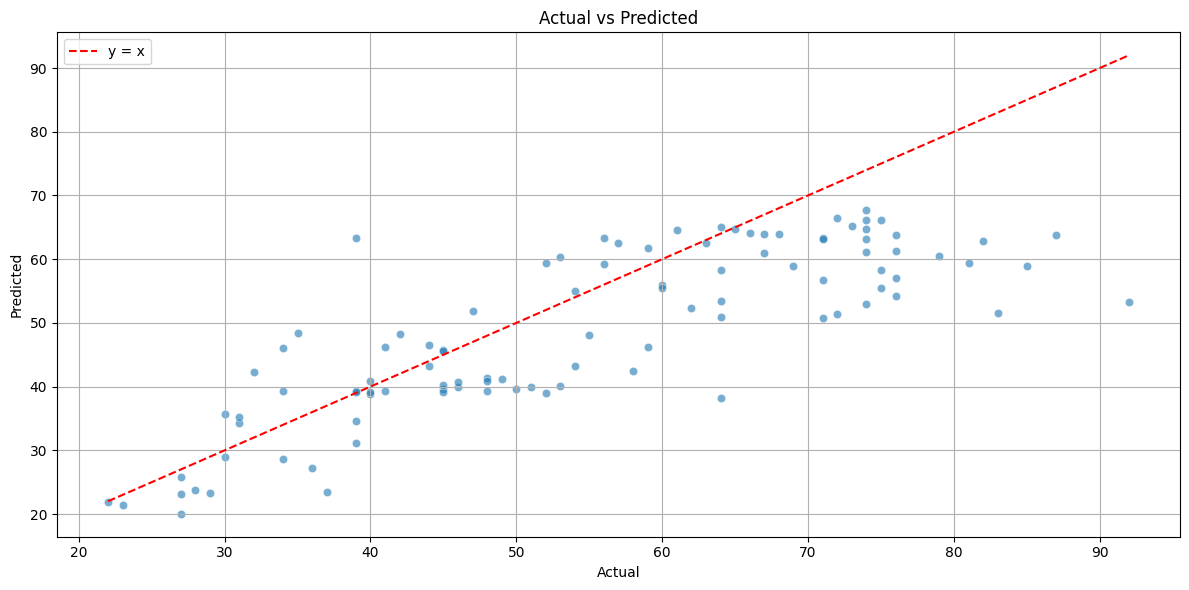

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:], y=y_pred_best, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

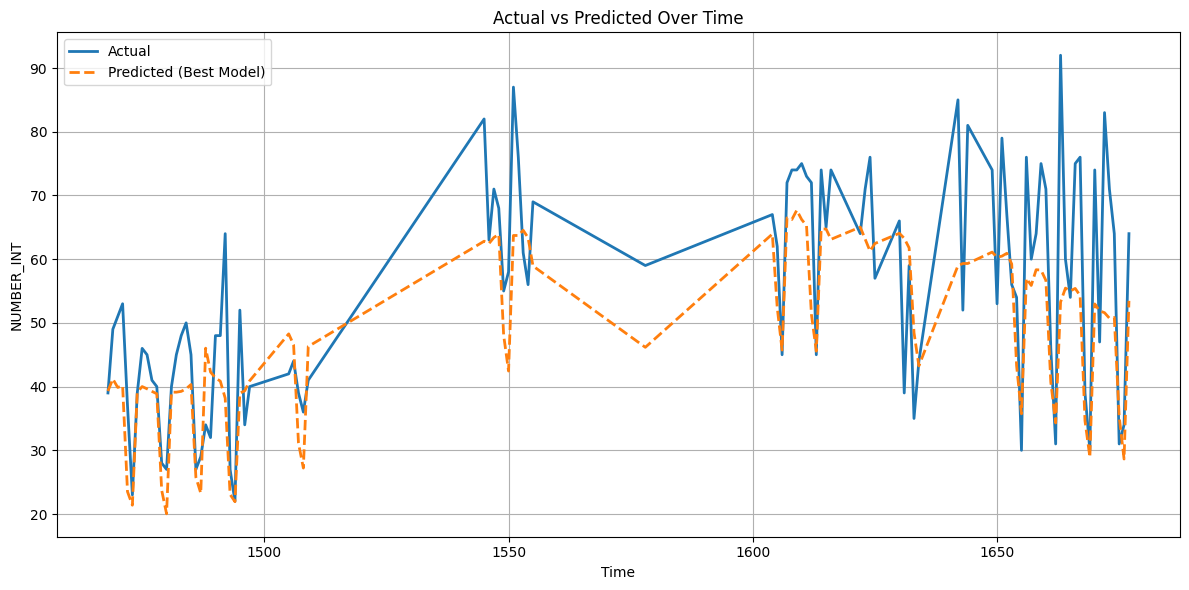

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred_best, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 30d

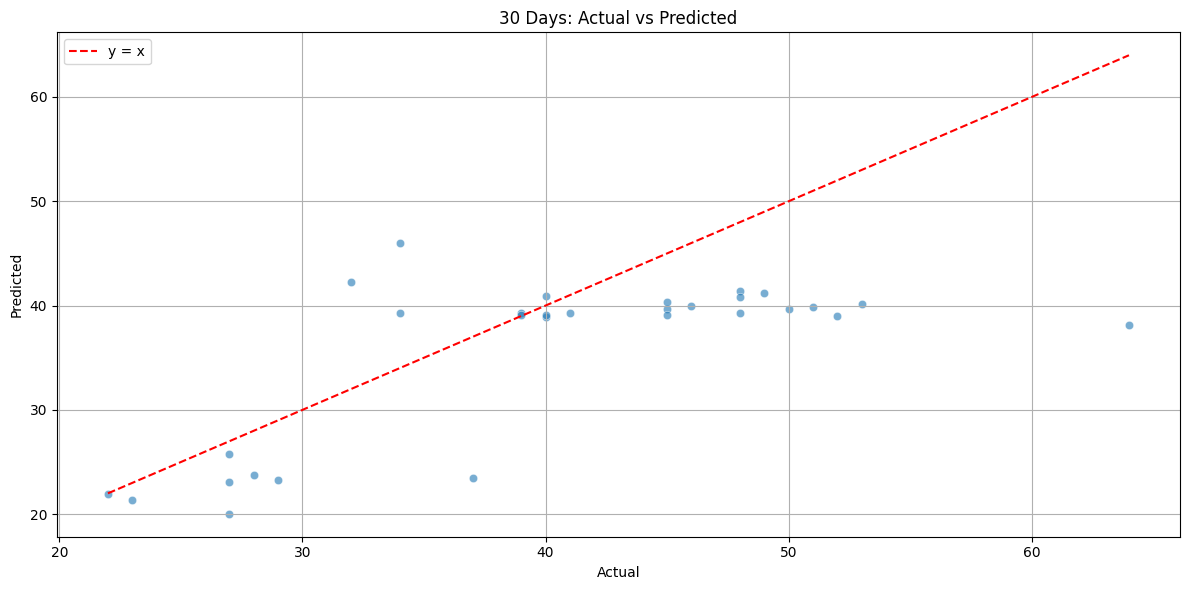

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:30], y=y_pred_best[:30], alpha=0.6)
plt.plot([y_val[:30].min(), y_val[:30].max()], [y_val[:30].min(), y_val[:30].max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('30 Days: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


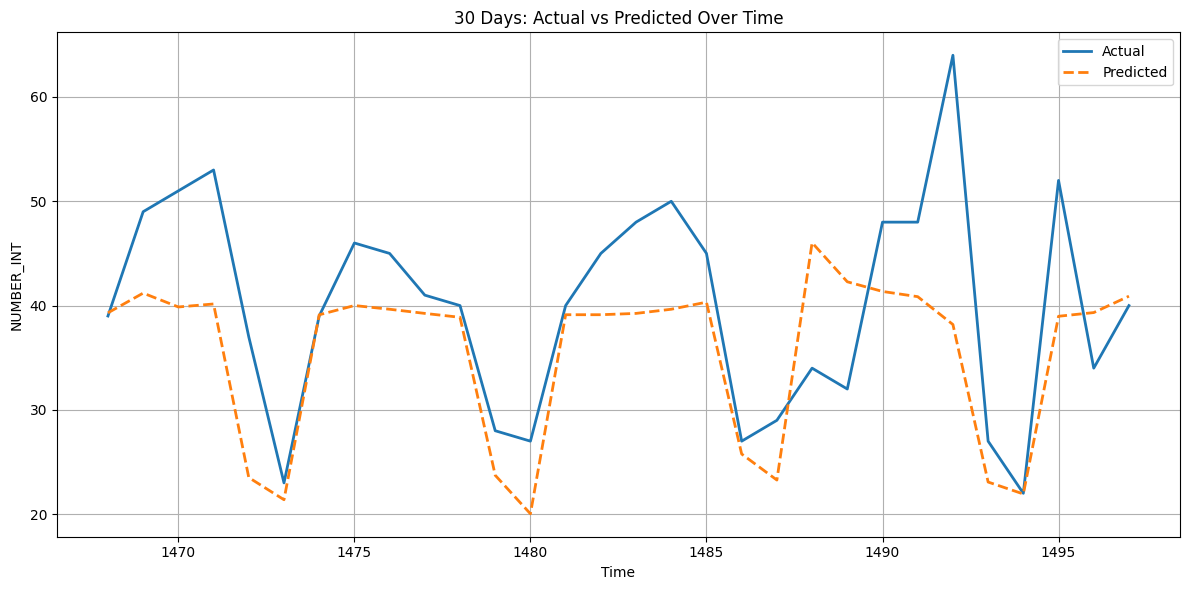

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index[:30], y_val[:30].values, label='Actual', linewidth=2)
plt.plot(y_val.index[:30], y_pred_best[:30], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title('30 Days: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

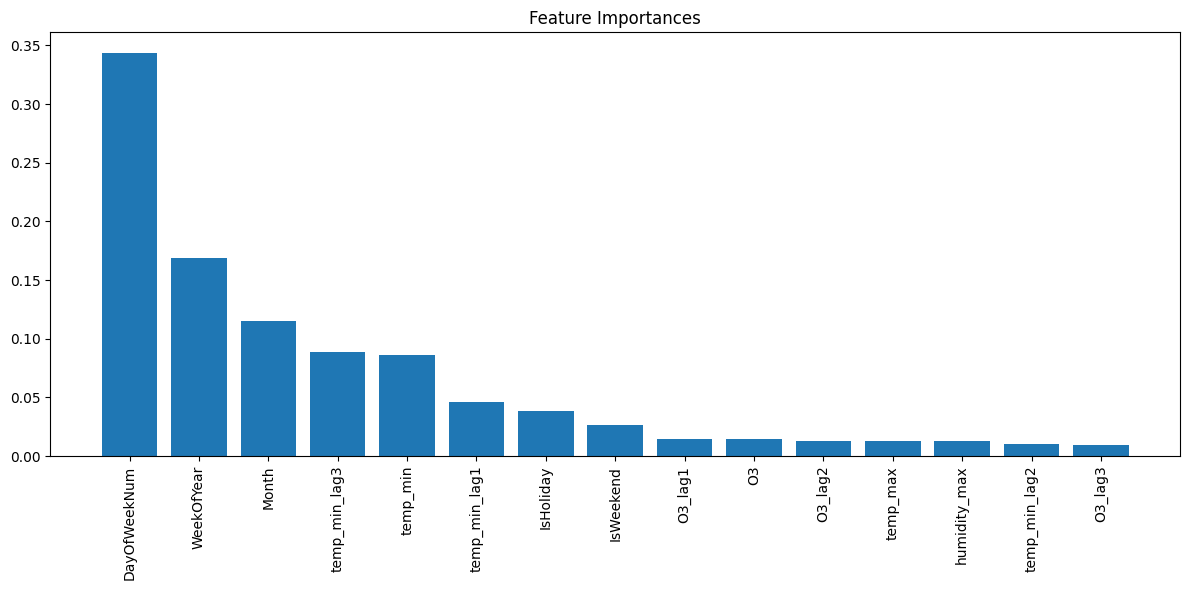

In [27]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()